## MDI230 - Projet Epidémiologie
Denis Fouchard, Victor Tabary et Thibaud Labat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
df = pd.read_csv('donnees-covid.csv', sep=';')
df.head()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,1,2020-03-19,1,0,0,0
1,1,2020-03-20,0,0,0,1
2,1,2020-03-21,3,0,0,0
3,1,2020-03-22,3,1,0,1
4,1,2020-03-23,14,1,0,5


## SIR Model

On se propose dans cette partie d'implémenter le modèle épidémiologique SIR, avec une population suposée constante $N$, et les paramètres $\beta$ and $\gamma$. 

Chaque individu infecté est contagieux durant une période aléatoire suivant une loi exponentielle de paramètre $\gamma$. 
Chaque individu est en contact avec un autrte individu à des instants suivant un processus de Poisson de paramètre $\beta$.

Le modèle est décrit par le système d'équations suivant :
$$\begin {align}
 \frac{dS}{dt}(t) &= -\beta S(t)I(t) \\
 \frac{dI}{dt}(t) &= \beta S(t)I(t) - \gamma I(t) \\
 \frac{dR}{dt}(t) &= \gamma I(t) \\
 \end{align}$$
avec $$S(t) + I(t) + R(t) = N.$$ 




On utilisera le modèle SIR déterministe. On introduit les variables temporelles réduites $s$, $i$, $r$ telles que :
$$\begin {align}
 S(t) &= s(t)N \\
 I(t) &= i(t)N \\
 R(t) &= r(t)N \\
 \end{align}$$

Le système précédent devient :
$$\begin {align}
 \frac{ds}{dt}(t) &= -\beta s(t)i(t) \\
 \frac{di}{dt}(t) &= \beta s(t)i(t) - \gamma i(t) \\
 \frac{dr}{dt}(t) &= \gamma i(t) \\
 \end{align}$$
with $$s(t) + i(t) + r(t) = 1.$$


In [3]:
def SIR(beta=0.02, gamma=0.01, i0=0.02, r0=0, T=50, plot=True):
    """
    Fonction qui simule un modèle SIR
    @param beta: taux de transmission
    @param gamma: taux de guérison
    @param i0: proportion initiale de la population infectée
    @param r0: proportion initiale de la population immunisée
    @return: s_list, i_list, r_list (listes des valeurs de S, I et R)
    """
    s = 1 - i0 - r0
    i = i0
    r = r0
    s_list = [s]
    i_list = [i]
    r_list = [r]

    sub = 24 # subdivisions par jour pour plus de précisions dans la dérivée
    for _ in range(sub*T):
        s, i, r = s - beta*s*i/sub, i + (beta*s*i - gamma*i)/sub, r + gamma*i/sub
        s_list.append(s)
        i_list.append(i)
        r_list.append(r)
    if plot:
        S_index = np.array(range(sub*T+1))/sub
        I_index = np.array(range(sub*T+1))/sub
        R_index = np.array(range(sub*T+1))/sub

        plt.plot(S_index, s_list, label='S')
        plt.plot(I_index, i_list, label='I')
        plt.plot(R_index, r_list, label='R')
        plt.legend()
        plt.xlabel('Temps (jours)')
        plt.title('Simulation du modèle SIR')
        plt.grid()
        plt.show()
    else:
        return s_list, i_list, r_list

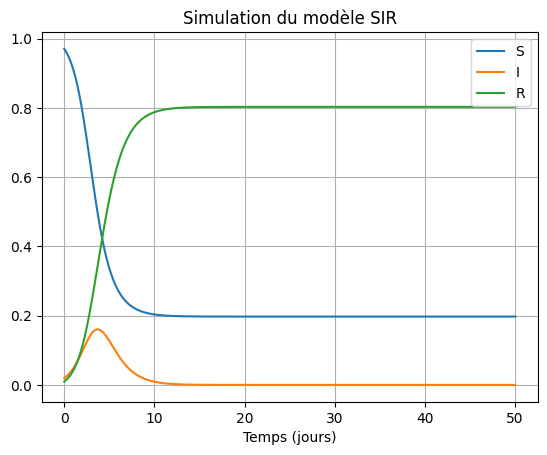

In [4]:
SIR(beta=2, gamma=1, i0=0.02,r0=0.01, plot=True)

## Markov Chain Modelisation

L'objectif est d'implémenter une modélisation épidémique suivant un processus de Markov, et de démontrer que ce modèle converge vers une modélisation SIR déterministe quand $N$ devient assez grand.

In [5]:
def markov_process_simulation(N=10000, beta=2, gamma=1, i0 = 0.02, r0=0, T=50, plot=True):
    """
    Fonction qui simule un processus de Markov
    @param N: taille de la population
    @param beta: taux de transmission
    @param gamma: taux de guérison
    @param i0: proportion initiale de la population infectée
    @param r0: proportion initiale de la population immunisée
    @return: S_list, I_list, R_list (listes des valeurs de S, I et R)
    """
    I, R = i0*N, r0*N
    S = N - I - R
    S_list = [S]
    I_list = [I]
    R_list = [R]

    for _ in range(T):
        for _ in range(N):
            # Calcul des taux de transition
            t1 = beta*S*I/N if S > 0 else 0
            t2 = gamma*I if I > 0 else 0

            p = np.random.rand()
            if p < t1/N:
                I += 1
                S -= 1
            elif t1/N < p < (t1+t2)/N:
                I -= 1
                R += 1

            S_list.append(S)
            I_list.append(I)
            R_list.append(R)

    S_list =np.array(S_list)/N
    I_list = np.array(I_list)/N
    R_list = np.array(R_list)/N
    if plot:
        T = np.array(range(T*N+1))/N
        plt.plot(T, S_list, label='S')
        plt.plot(T, I_list, label='I')
        plt.plot(T, R_list, label='R')
        plt.xlabel('Temps (jours)')
        plt.legend()
        plt.title('Simulation du modèle markovien')
        plt.grid()
        plt.show()
    else:
        # Take only T values (not T*N) 
        S_list = S_list[::N]
        I_list = I_list[::N]
        R_list = R_list[::N]
        return S_list, I_list, R_list


In [6]:
## Quelques optimisations au code précédent (une seule boucle au lieu de deux)

def markov_process_simulation_optimized(N=10000, beta=2, gamma=1, i0 = 0.02, r0=0, T=50, plot=True):
    """
    Fonction qui simule un processus de Markov
    @param N: taille de la population
    @param beta: taux de transmission
    @param gamma: taux de guérison
    @param i0: proportion initiale de la population infectée
    @param r0: proportion initiale de la population immunisée
    @return: S_list, I_list, R_list (listes des valeurs de S, I et R)
    """
    # Using numpy arrays instead of lists
    I, R = i0*N, r0*N
    S = N - I - R
    S_list = np.zeros(T*N+1)
    I_list = np.zeros(T*N+1)
    R_list = np.zeros(T*N+1)
    S_list[0] = S
    I_list[0] = I
    R_list[0] = R

    for i in range(1, T*N+1):

        # Calcul des taux de transition
        t1 = beta*S*I/N if S > 0 else 0
        t2 = gamma*I if I > 0 else 0

        p = np.random.rand()
        if p < t1/N:
            I += 1
            S -= 1
        elif t1/N < p < (t1+t2)/N:
            I -= 1
            R += 1

        S_list[i] = S
        I_list[i] = I
        R_list[i] = R

    S_list = S_list/N
    I_list = I_list/N
    R_list = R_list/N
    if plot:
        T = np.array(range(T*N+1))/N
        plt.plot(T, S_list, label='S')
        plt.plot(T, I_list, label='I')
        plt.plot(T, R_list, label='R')
        plt.xlabel('Temps (jours)')
        plt.legend()
        plt.title('Simulation du modèle markovien')
        plt.grid()
        plt.show()
    else:
        # Take only T values (not T*N) 
        S_list = S_list[::N]
        I_list = I_list[::N]
        R_list = R_list[::N]
        return S_list, I_list, R_list

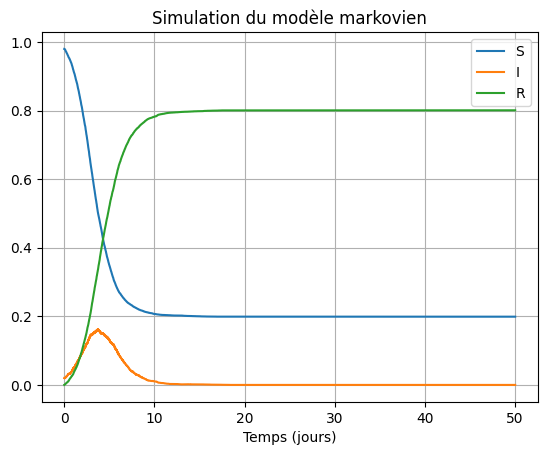

In [7]:
markov_process_simulation(N=10000, beta=2, gamma=1, i0 = 0.02, r0=0, plot=True)

On recherche des paramètres $\beta$ et $\gamma$ tels que la population entière finit par être retirée, c'est à dire que $R(\infty) = N$.

Empiriquement, les valeurs $(7, 1)$ et $(2, 1/7)$ conviennent.

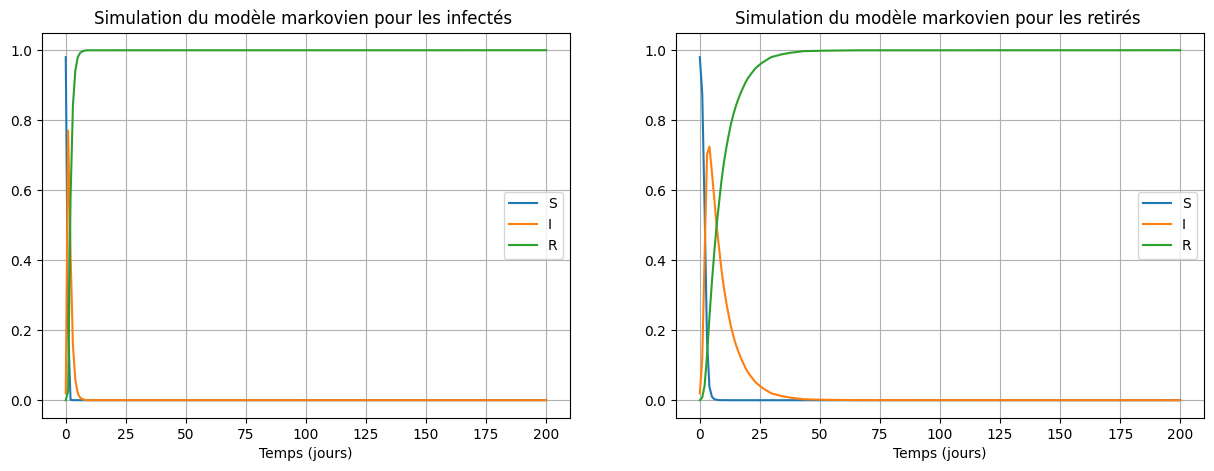

In [8]:
beta_retired, gamma_retired = [7, 2], [1, 1/7]
## Plot in a single plot the results of the simulations for the two groups
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    s_list, i_list, r_list = markov_process_simulation(N=10000, beta=beta_retired[i], gamma=gamma_retired[i], i0 = 0.02, r0=0, T=200, plot=False)
    T = np.array(range(len(s_list)))
    ax[i].plot(T, s_list, label='S')
    ax[i].plot(T, i_list, label='I')
    ax[i].plot(T, r_list, label='R')
    ax[i].set_xlabel('Temps (jours)')
    ax[i].set_title('Simulation du modèle markovien pour les {} '.format(['infectés', 'retirés'][i]))
    ax[i].legend()
    ax[i].grid()
    
plt.show()




On recherche des paramètres $\beta$ et $\gamma$ tels qu'une partie de la population reste toujours suceptible, c'est à dire que $S(\infty) > 0$.

Empiriquement, les valeurs $(1, 1)$ et $(2, 1)$ conviennent.

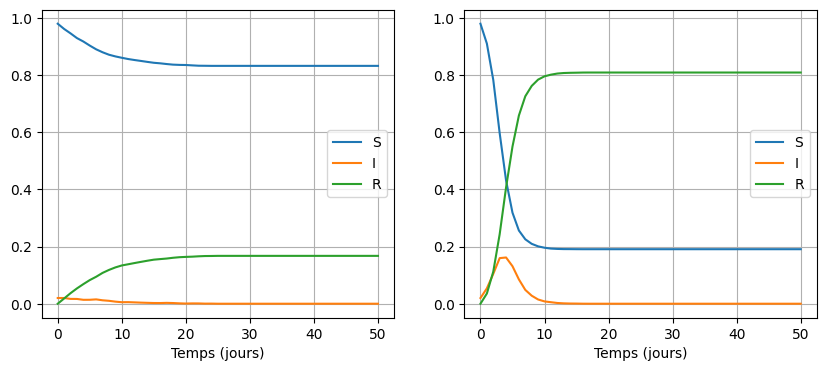

In [9]:
beta_mixed, gamma_mixed = [1, 2], [1, 1,]
## Plot in a single plot the results of the simulations for the two groups
k = len(beta_mixed)
fig, ax = plt.subplots(1, k, figsize=(5*k, 4))

for i in range(k):
    s_list, i_list, r_list = markov_process_simulation(N=10000, beta=beta_mixed[i], gamma=gamma_mixed[i], i0 = 0.02, r0=0, plot=False)
    T = np.array(range(len(s_list)))
    ax[i].plot(T, s_list, label='S')
    ax[i].plot(T, i_list, label='I')
    ax[i].plot(T, r_list, label='R')
    ax[i].set_xlabel('Temps (jours)')
    ax[i].legend()
    ax[i].grid()
    
plt.show()

## Convergence du modèle de Markov vers le modèle déterministe

In [10]:
def convergence_markov(N=1000, beta=0.2, gamma=0.1, i0=0.02, r0=0.02, T=100, plot=True):
    # Initialisation
    s_list, i_list, r_list = markov_process_simulation(N=N, beta=beta, gamma=gamma, i0=i0, r0=r0, T=T, plot=False)
    S_list, I_list, R_list = SIR(beta=beta, gamma=gamma, i0=i0, r0=r0, T=T, plot=False)
    T_markov = np.array(range(T*N+1))/N
    T = np.array(range(T+1))
    # Plot
    if plot:
        plt.plot(T_markov, s_list, label='S')
        plt.plot(T_markov, i_list, label='I')
        plt.plot(T_markov, r_list, label='R')
        plt.plot(T, S_list, label='S (SIR)')
        plt.plot(T, I_list, label='I (SIR)')
        plt.plot(T, R_list, label='R (SIR)')
        plt.xlabel('Temps (jours)')
        plt.legend()
        plt.title('Simulation du modèle markovien')
        plt.grid()
        plt.show()

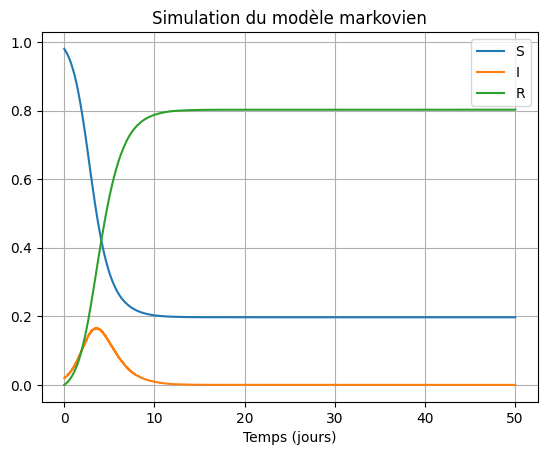

In [11]:
markov_process_simulation_optimized(N=200000, beta=2, gamma=1, i0=0.02, r0=0, plot=True)

100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


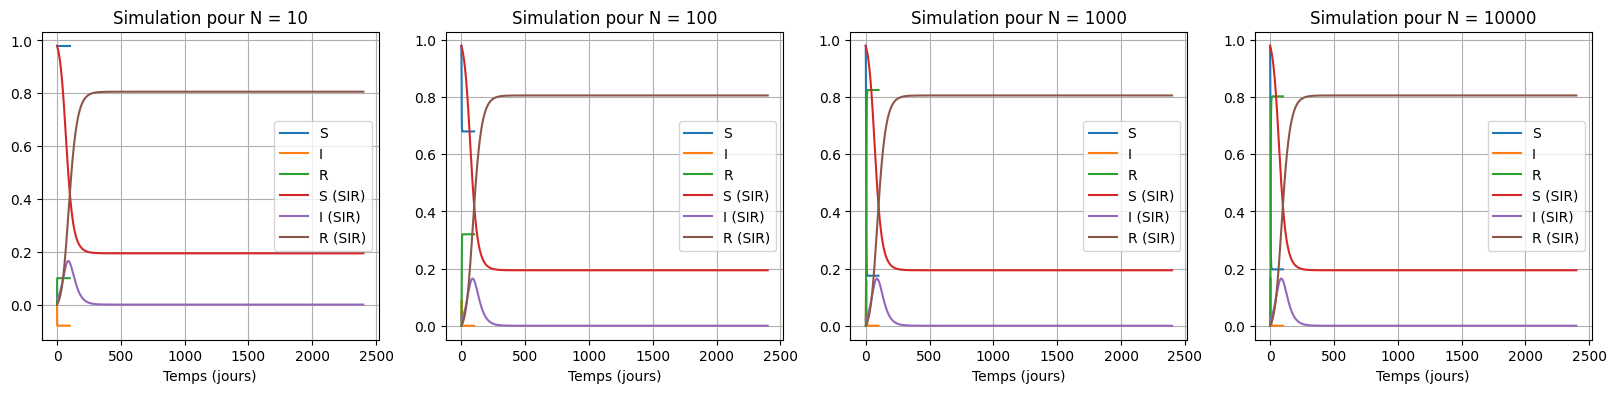

In [12]:
# Plot the results of the simulations for the two groups in a single subplot for different values of N
from tqdm import tqdm

N_list = [10, 100, 1000, 10000]
fig, ax = plt.subplots(1, len(N_list), figsize=(5*len(N_list), 4))

N_jours = 100

for i in tqdm(range(len(N_list))):

    # Markov process simulation
    s_list, i_list, r_list = markov_process_simulation_optimized(N=N_list[i], beta=2, gamma=1, i0=0.02, r0=0, T=N_jours, plot=False)
    T = np.array(range(len(s_list)))
    ax[i].plot(T, s_list, label='S')
    ax[i].plot(T, i_list, label='I')
    ax[i].plot(T, r_list, label='R')

    
    # SIR model
    S_list, I_list, R_list = SIR(beta=2, gamma=1, i0=0.02, r0=0, T=N_jours, plot=False)
    T = np.array(range(len(S_list)))
    ax[i].plot(T, S_list, label='S (SIR)')
    ax[i].plot(T, I_list, label='I (SIR)')
    ax[i].plot(T, R_list, label='R (SIR)')

    ax[i].set_xlabel('Temps (jours)')
    ax[i].set_title('Simulation pour N = {}'.format(N_list[i]))
    ax[i].legend()
    ax[i].grid()

plt.show()

On remarque bien une convergence assez rapide des deux modèles.

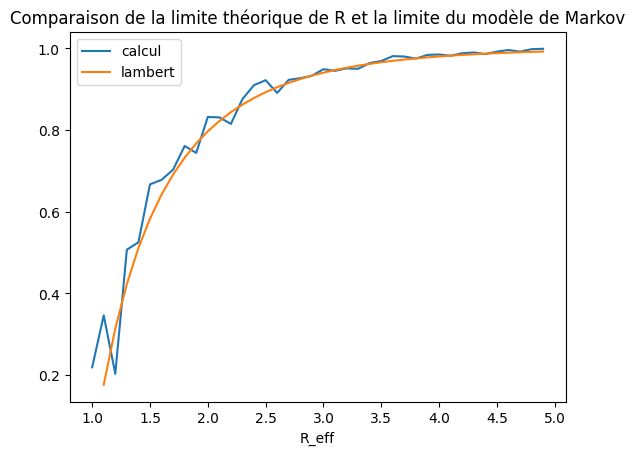

In [23]:
from scipy.special import lambertw

R_lim_calcul = []
R_lim_theorique = []
for r_eff in range(10,50):
    _, _, r = markov_process_simulation_optimized(N=1000, beta=r_eff/10, gamma=1, i0 = 0.02, r0=0, T = 100, plot=False)
    R_lim_calcul.append(r[-1])
    R_lim_theorique.append(1+10/r_eff*lambertw(-r_eff/10*np.exp(-r_eff/10)))

plt.plot([r_eff/10 for r_eff in range(10,50)], R_lim_calcul, label='calcul')
plt.plot([r_eff/10 for r_eff in range(10,50)], R_lim_theorique, label='lambert')
plt.xlabel('R_eff')
plt.legend()
plt.title('Comparaison de la limite théorique de R et la limite du modèle de Markov')
plt.show()

## Question ouverte

On se propose d'estimer les paramètres $\gamma$ et $\beta$ à partir des données empiriques disponibles sur data.gouv.fr.

On rappelle les équations du modèle SIR déterministe :
$$\begin {align}
 \frac{ds}{dt}(t) &= -\beta s(t)i(t) \\
 \frac{di}{dt}(t) &= \beta s(t)i(t) - \gamma i(t) \\
 \frac{dr}{dt}(t) &= \gamma i(t) \\
 \end{align}$$


On note $\hat{s}(t)$, $\hat{i}(t)$ et $\hat{r}(t)$ les valeurs estimées des fonctions $s$, $i$ et $r$ aux instants $t_0, t_1, \dots, t_n$.



In [13]:
# On fait un test préliminaire sur le département 75
df_test = df[df['dep'] == '75']
T = df_test['jour'].to_numpy()
df_test.head()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
19800,75,2020-03-19,167,41,11,31
19801,75,2020-03-20,120,21,5,28
19802,75,2020-03-21,138,34,7,35
19803,75,2020-03-22,147,31,4,33
19804,75,2020-03-23,189,31,18,33


Les valeurs de $\hat{i'}(t)$ et $\hat{r'}(t)$ sont données directement par les colones du jeu de données. On ignore les admissions en réanimation car ils sont inclus dans les hospitalisations. 

On détermine $\hat{i(t)}$ en calculant le nombre de cas actifs à l'instant $t$ à partir des données empiriques. On détermine $\hat{s(t)}$ et $\hat{r(t)}$ en utilisant les équations du modèle SIR déterministe.

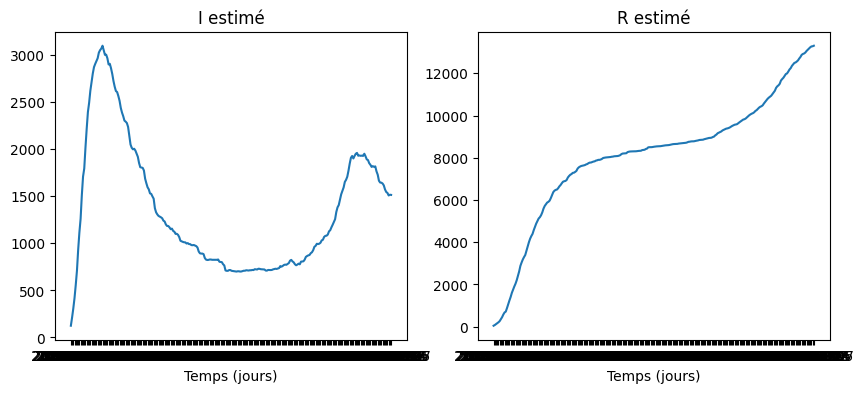

In [14]:
# On estime la population du département 75
N_75 = 2e6


# On rajoute les colonnes S, I, R
df_test['dI'] = df_test['incid_hosp'] 
df_test['dR'] = df_test['incid_rad'] + df_test['incid_dc']
df_test['dS'] = - df_test['dI'] - df_test['dR']

# On prend les données cumulées pour S, I, R
df_test['R'] = df_test['dR'].cumsum()
df_test['I'] = df_test['dI'].cumsum() - df_test['R']
df_test['S'] = N_75 - df_test['I'] - df_test['R']

# On somme sur tous les départements
df_test = df_test.groupby('jour').sum()

# On affiche les données cumulées pour S, I, R echelle log
I = df_test['I'].to_numpy()
R = df_test['R'].to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(T, I, label='I')
ax[0].title.set_text('I estimé')
ax[0].set_xlabel('Temps (jours)')
ax[1].plot(T, R, label='R')
ax[1].title.set_text('R estimé')
ax[1].set_xlabel('Temps (jours)')

plt.show()




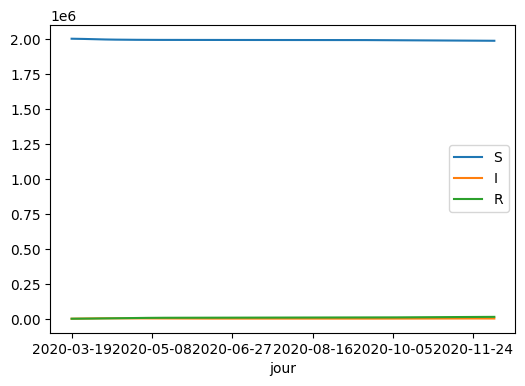

In [15]:
# et sur un même graphique
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df_test[['S']].plot(ax=ax)
df_test[['I']].plot(ax=ax)
df_test[['R']].plot(ax=ax)

plt.show()

Le problème est que l'on ne peut pas exactement estimer la population totale effective. Lorsqu'on a un cluster de malades, la population totale de la France n'est pas nécessairement concernée, ce qui fait que la population totale est très largement surestimée. Cela rend difficile d'afficher sur un même graphe les données $S$, $I$ et $R$, sachant que $S$ est très proche de $N$.

Maintnenant qu'on sait que ça fonctionne on peut refaire sur toute la France

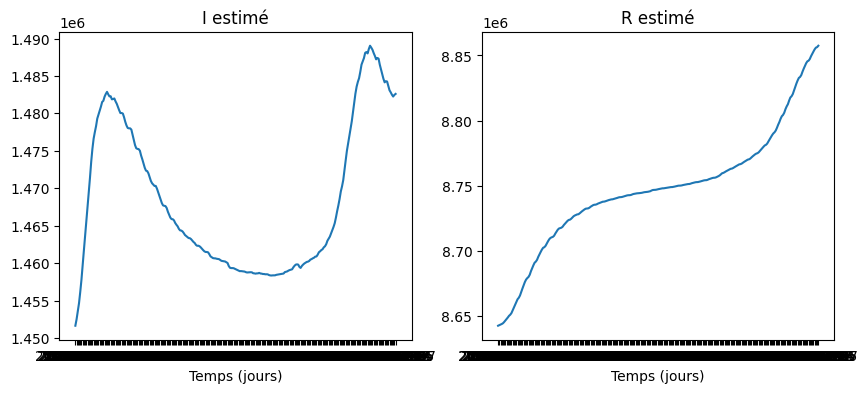

In [16]:
# On refait la meme chose pour toute la France (en prenant la population totale)
df_test = df
N = 67e6

# On rajoute les colonnes S, I, R
df_test['dI'] = df_test['incid_hosp'] 
df_test['dR'] = df_test['incid_rad'] + df_test['incid_dc']
df_test['dS'] = - df_test['dI'] - df_test['dR']

# On prend les données cumulées pour S, I, R
df_test['R'] = df_test['dR'].cumsum()
df_test['I'] = df_test['dI'].cumsum() - df_test['R']
df_test['S'] = N - df_test['I'] - df_test['R']

# On somme sur tous les départements
df_test = df_test.groupby('jour').sum()

# On affiche les données cumulées pour S, I, R echelle log
I_cum = df_test['I'].to_numpy()
R_cum = df_test['R'].to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(T, I_cum, label='I')
ax[0].title.set_text('I estimé')
ax[0].set_xlabel('Temps (jours)')
ax[1].plot(T, R_cum, label='R')
ax[1].title.set_text('R estimé')
ax[1].set_xlabel('Temps (jours)')

plt.show()


Maintenant, on réutilise les équations du modèle SIR déterministe pour déterminer $\hat{\gamma}$ et $\hat{\beta}$.

On a donc :
$$ \hat{\gamma} = \frac{\hat{r}(t)'}{\hat{i}(t)} $$
et
$$ \hat{\beta} = \frac{\hat{i}(t)'}{\hat{s}(t)\hat{i}(t)} $$


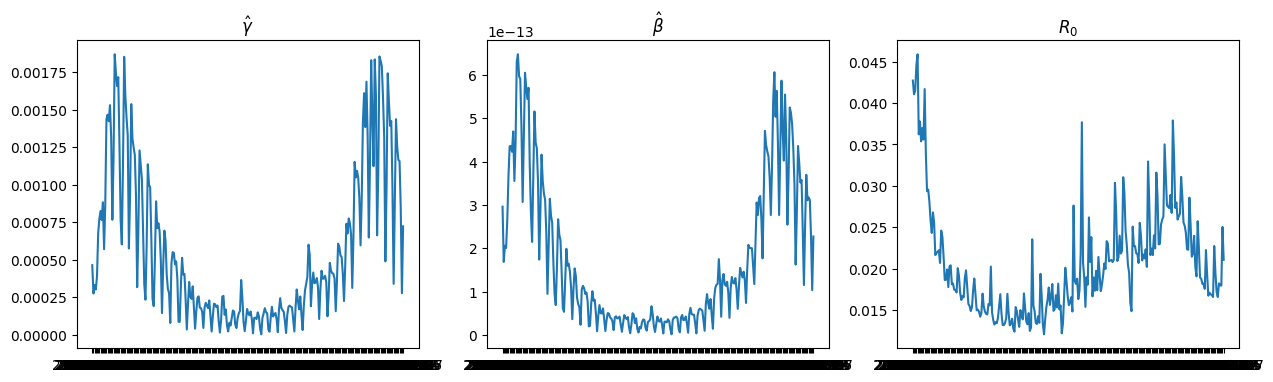

In [17]:
gamma = df_test['dR']/df_test['I']
gamma = gamma.to_numpy()
beta = - df_test['dS'] / (df_test['S'] * df_test['I'])
beta = beta.to_numpy()
R0 = N * beta/gamma

# plot gamma, beta, R0
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(T, gamma)
ax[0].set_title(r'$\hat{\gamma}$')
ax[1].plot(T, beta)
ax[1].set_title(r'$\hat{\beta}$')

ax[2].plot(T, R0)
ax[2].set_title(r'$R_0$')


plt.show()

On a besoin de lisser les valeurs de $\hat{gamma}$ et $\hat{beta}$ pour avoir des valeurs plus lisibles. En effet le décompte des hospitalisation, réanimations peut être impacté par le jour de prise en charge (WE, etc...). On remarque une sorte de périodicité de une semaine dans les courbes en plus des variations dues aux circonstances de l'épidémie. 

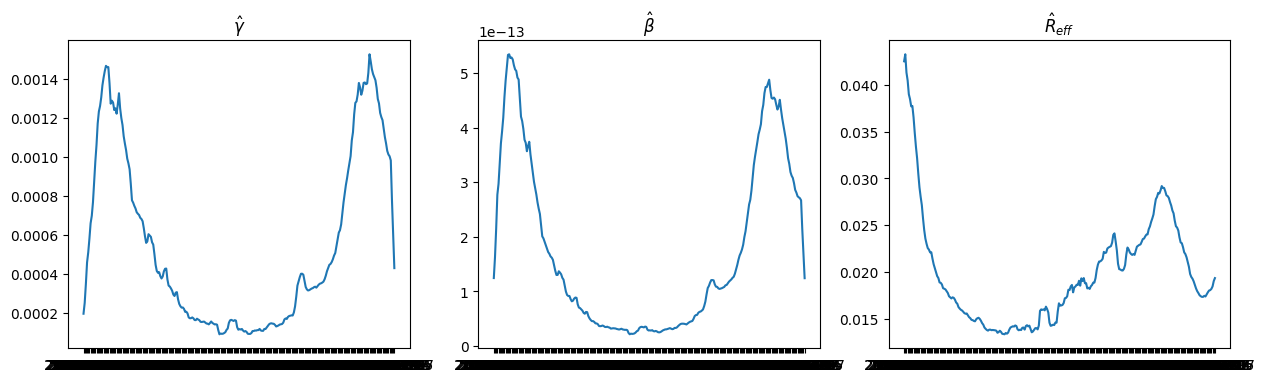

In [18]:
# Lissage moyenne sur 7 jours
kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size
gamma = np.convolve(gamma, kernel, mode='same')
beta = np.convolve(beta, kernel, mode='same')
R_eff = N * beta/gamma

# plot gamma, beta, R_eff
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(T, gamma)
ax[0].set_title(r'$\hat{\gamma}$')
ax[1].plot(T, beta)
ax[1].set_title(r'$\hat{\beta}$')

ax[2].plot(T, R_eff)
ax[2].set_title(r'$\hat{R}_{eff}$')

plt.show()

On compare avec des données R-effectif fournies par data.gouv.fr.

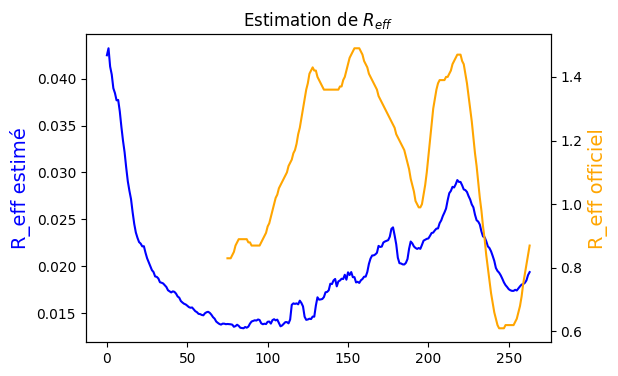

In [24]:
df_R_eff = pd.read_csv("/work/table-indicateurs-open-data-france.csv")

# Only take values from 2020-03-19 to 2020-12-07
df_test_reduced = df_test.loc['2020-03-19':]
df_R_eff_reduced = df_R_eff.loc[:'2020-12-06']
R_eff_empirical = df_R_eff_reduced["R"]

gamma = df_test_reduced['dR']/df_test_reduced['I']
gamma = gamma.to_numpy()
beta = - df_test_reduced['dS'] / (df_test_reduced['S'] * df_test_reduced['I'])
beta = beta.to_numpy()

# Lissage
kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size
gamma = np.convolve(gamma, kernel, mode='same')
beta = np.convolve(beta, kernel, mode='same')
R_eff_reduced = N * beta/gamma

T_reduced = np.arange(0, len(R_eff_reduced))


# plot R_eff
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(T_reduced, R_eff_reduced, color="blue")
ax2 = ax.twinx()
ax2.plot(T_reduced, R_eff_empirical, color='orange')
ax.set_ylabel(ylabel='R_eff estimé', color="blue", fontsize=14)
ax2.set_ylabel(ylabel='R_eff officiel', color="orange", fontsize=14)
ax.set_title(r'Estimation de $R_{eff}$')


plt.show()

On observe des tendances similaires, mais des valeurs différentes. Cela est du au fait que $S$ est très proche de $N$, que nous avons eu du mal à estimer. 

On affiche une version adaptée de $R_{eff}$ estimé, modifié d'un facteur adaptatif constant.

Ce facteur est le quotient des valeurs de $R_{eff}$ empirique et $R_{eff}$ estimé moyennées sur toute la période de mesure de $R_{eff}$ empirique.

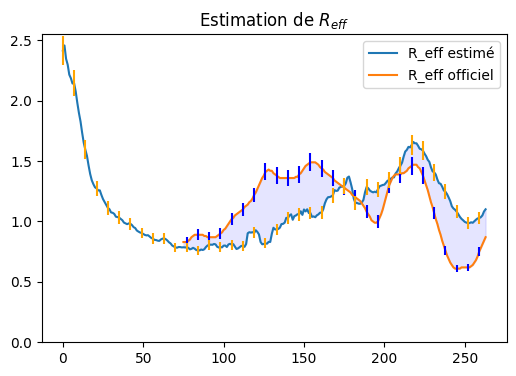

In [20]:
adaptative_factor = R_eff_empirical.mean()/R_eff_reduced[-len(R_eff_empirical):].mean()

R_eff_reduced *= adaptative_factor

T_reduced = np.arange(0, len(R_eff_reduced))

# plot R_eff
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(T_reduced, R_eff_reduced, label='R_eff estimé')
ax.plot(T_reduced, R_eff_empirical, label='R_eff officiel')
ax.legend()
ax.set_title(r'Estimation de $R_{eff}$')
ax.set_ylim(bottom=0)
ax.fill_between(T_reduced, R_eff_reduced, R_eff_empirical, color='b', alpha=.1)

#Ajout de barres d'erreurs à 5% sur les données 
for i in range(0, len(R_eff_empirical), 7):
    ax.errorbar(i, R_eff_empirical[i], yerr=0.05*R_eff_empirical[i], color='b')
for i in range(0, len(R_eff_reduced), 7):
    ax.errorbar(i, R_eff_reduced[i], yerr=0.05*R_eff_reduced[i], color='orange')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e96e4720-4217-47da-a179-ccf8fbfac53e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>